# RL for Sum of Discounted Reward
- Lagrange RL
- Mayer RL

In [1]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

from gym_reachability import gym_reachability  # Custom Gym env.
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from collections import namedtuple

from KC_DQN.DDQN import DDQN
from KC_DQN.config import dqnConfig

In [2]:
#== CONFIGURATION ==
env_name = "zermelo_kc-v0"
print('='*4 + ' CONFIGURATION ' + '='*4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIG = dqnConfig(DEVICE=device, BATCH_SIZE=200, ENV_NAME=env_name, GAMMA=0.9, MAX_EPISODES=40000, MAX_EP_STEPS=100, MEMORY_CAPACITY=20000,
                   EPS_PERIOD=2000, EPS_DECAY=0.6,
                   LR_C_PERIOD=4000, LR_C_DECAY=0.8)
for key, value in CONFIG.__dict__.items():
    if key[:1] != '_': 
        print(key, ': ', value)

==== CONFIGURATION ====
MAX_EPISODES :  40000
MAX_EP_STEPS :  100
EPSILON :  0.95
EPS_END :  0.05
EPS_PERIOD :  2000
EPS_DECAY :  0.6
LR_C :  0.01
LR_C_PERIOD :  4000
LR_C_DECAY :  0.8
MEMORY_CAPACITY :  20000
BATCH_SIZE :  200
GAMMA :  0.9
TAU :  0.01
HARD_UPDATE :  1
SOFT_UPDATE :  True
RENDER :  False
ENV_NAME :  zermelo_kc-v0
MAX_MODEL :  5
DEVICE :  cpu
DOUBLE :  True


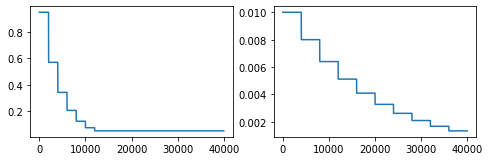

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(8,2.4))

eps = np.zeros(CONFIG.MAX_EPISODES)
lr = np.zeros(CONFIG.MAX_EPISODES)
eps_tmp = CONFIG.EPSILON
lr_tmp = CONFIG.LR_C
for i in range(CONFIG.MAX_EPISODES):
    if i != 0 and i % CONFIG.EPS_PERIOD == 0:
        eps_tmp *= CONFIG.EPS_DECAY
    if i != 0 and i % CONFIG.LR_C_PERIOD == 0:
        lr_tmp *= CONFIG.LR_C_DECAY
    eps[i] = max(eps_tmp, 0.05)
    lr[i] = lr_tmp
ax[0].plot(np.arange(CONFIG.MAX_EPISODES), eps)
ax[1].plot(np.arange(CONFIG.MAX_EPISODES), lr)

In [4]:
# == Environment ==
env = gym.make(env_name, device=device)
print(env.observation_space)
print(env.bounds)

# == Discretization ==
grid_cells = (41, 121)
num_states = np.cumprod(grid_cells)[-1]
state_bounds = env.bounds
env.set_discretization(grid_cells, state_bounds)
print(env.spec.id)

s_dim = env.observation_space.shape[0]
action_num = env.action_space.n
print(s_dim, action_num)

action_list = np.arange(action_num)

Box(2,)
[[-1.9   1.9 ]
 [-2.    9.25]]
zermelo_kc-v0
2 3


/Users/kaichieh/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Ep[  0] - [0.95/1.0e-02]: Running cost: 3.93 	 Real cost: 39.32


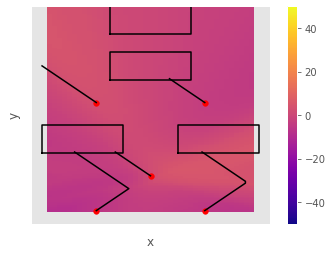

Ep[2000] - [0.57/1.0e-02]: Running cost: 36.00 	 Real cost: -22.40


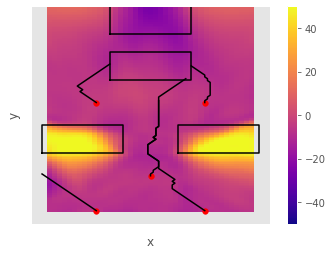

Ep[4000] - [0.34/8.0e-03]: Running cost: 33.66 	 Real cost: -21.60


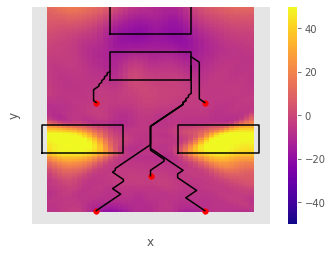

Ep[6000] - [0.21/8.0e-03]: Running cost: 20.37 	 Real cost: 24.70


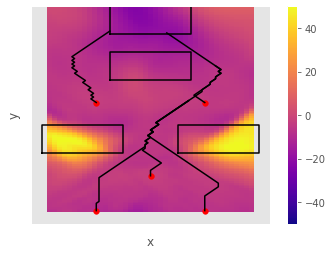

Ep[8000] - [0.12/6.4e-03]: Running cost: 16.65 	 Real cost: 23.95


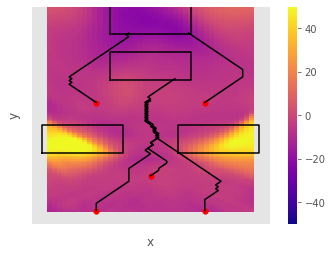

Ep[10000] - [0.07/6.4e-03]: Running cost: -1.63 	 Real cost: -37.00


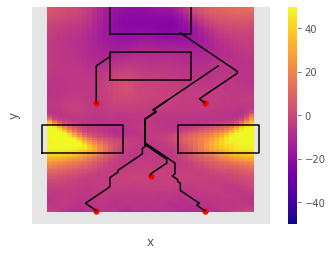

Ep[12000] - [0.05/5.1e-03]: Running cost: 1.58 	 Real cost: 50.00


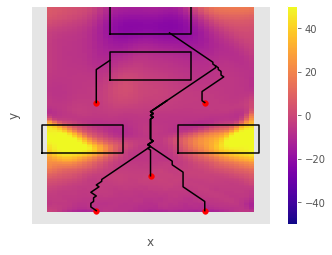

Ep[14000] - [0.05/5.1e-03]: Running cost: 23.23 	 Real cost: 50.00


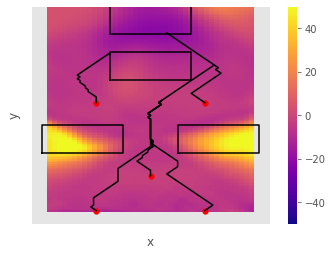

Ep[16000] - [0.05/4.1e-03]: Running cost: 8.93 	 Real cost: 34.00


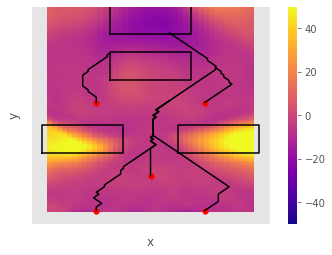

Ep[18000] - [0.05/4.1e-03]: Running cost: -2.30 	 Real cost: -19.60


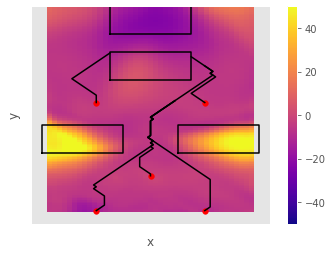

Ep[20000] - [0.05/3.3e-03]: Running cost: -26.82 	 Real cost: -62.60


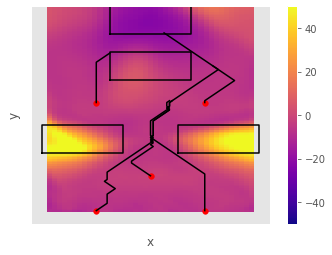

Ep[22000] - [0.05/3.3e-03]: Running cost: 2.50 	 Real cost: 50.00


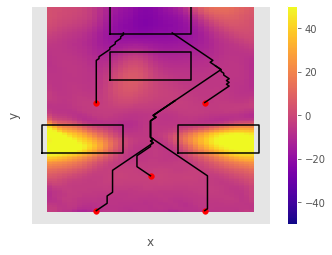

Ep[24000] - [0.05/2.6e-03]: Running cost: -23.55 	 Real cost: -31.27


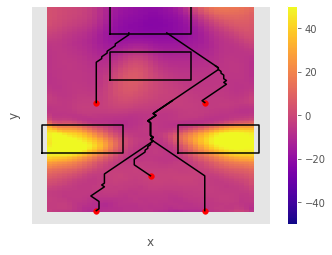

Ep[26000] - [0.05/2.6e-03]: Running cost: 13.56 	 Real cost: 50.53


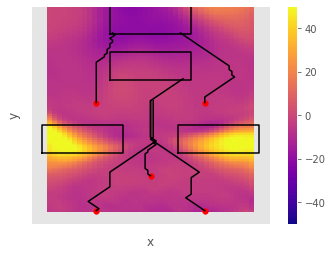

Ep[28000] - [0.05/2.1e-03]: Running cost: 9.51 	 Real cost: 48.30


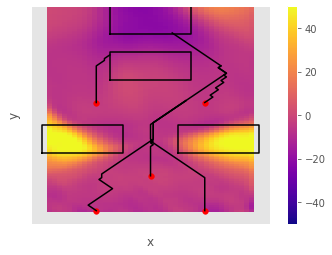

Ep[30000] - [0.05/2.1e-03]: Running cost: 6.04 	 Real cost: 50.00


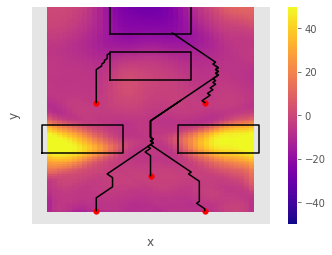

Ep[32000] - [0.05/1.7e-03]: Running cost: -10.06 	 Real cost: -60.20


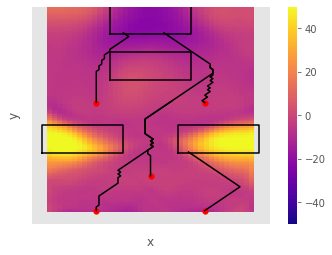

Ep[34000] - [0.05/1.7e-03]: Running cost: -1.97 	 Real cost: -21.60


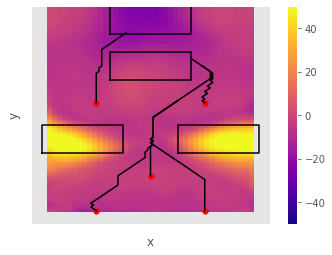

Ep[36000] - [0.05/1.3e-03]: Running cost: -2.26 	 Real cost: 49.11


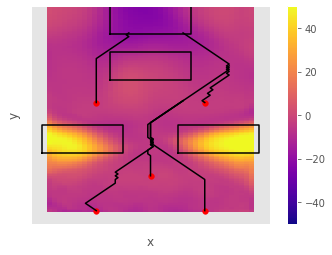

Ep[38000] - [0.05/1.3e-03]: Running cost: 14.19 	 Real cost: 50.00


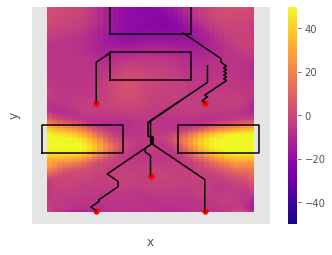

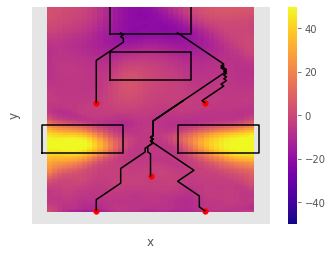

In [5]:
#== AGENT ==
agent=DDQN(s_dim, action_num, CONFIG, action_list)
#== TRAINING RECORD ==
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'avg_cost', 'cost', 'loss_c'])
training_records = []
running_cost = 0.
running_cost_th = -950.
report_period = 2000

while len(agent.memory) < agent.BATCH_SIZE*20:
    s = env.reset()
    a, a_idx = agent.select_action(s)
    s_, r, done, _ = env.step(a_idx)
    if done:
        s_ = None
    agent.store_transition(s, a_idx, r, s_)

for ep in range(CONFIG.MAX_EPISODES):
    s = env.reset()
    ep_cost = 0.
    cnt = 0
    for step_num in range(CONFIG.MAX_EP_STEPS):
        cnt+=1
        if CONFIG.RENDER:
            env.render()
        # action selection
        a, a_idx = agent.select_action(s)

        # interact with env
        s_, r, done, _ = env.step(a_idx)
        
        ep_cost += r
        if done:
            s_ = None

        # Store the transition in memory
        agent.store_transition(s, a_idx, r, s_)
        s = s_

        # Perform one step of the optimization (on the target network)
        loss_c = agent.update()
        if done:
            break
            
    agent.updateHyperParam()
    running_cost = running_cost * 0.9 + ep_cost * 0.1
    training_records.append(TrainingRecord(ep, running_cost, ep_cost, loss_c))
    print('{:d}: {:.1f} after {:d} steps   '.format(ep, ep_cost, cnt), end='\r')
    
    if ep % report_period == 0:
        lr = agent.optimizer.state_dict()['param_groups'][0]['lr']
        print('\rEp[{:3.0f}] - [{:.2f}/{:.1e}]: Running cost: {:3.2f} \t Real cost: {:.2f}'.format(ep, agent.EPSILON, lr, 
                                                                                                   running_cost, ep_cost))
        env.visualize_analytic_comparison(agent.Q_network, True)
        env.plot_trajectories(agent.Q_network, T=60, num_rnd_traj=5, states=env.visual_initial_states)
        plt.pause(0.001)
    
    if running_cost <= running_cost_th:
        print("\r At Ep[{:3.0f}] Solved! Running cost is now {:3.2f}!".format(ep, running_cost))
        env.close()
        break
    
env.visualize_analytic_comparison(agent.Q_network, True)
env.plot_trajectories(agent.Q_network, T=60, num_rnd_traj=5, states=env.visual_initial_states)

[[ 1.55405068  0.52496743 -0.61940932 ...  3.45178795  3.47028923
   3.46512794]
 [-1.31764388 -1.73768592 -2.26987052 ...  2.99481773  3.02767754
   3.0404644 ]
 [-4.81696129 -4.3933754  -4.67208576 ...  2.3770771   2.43970299
   2.48332405]
 ...
 [-4.56908131 -6.37636089 -6.54470348 ...  5.31195259  5.77934456
   6.17847252]
 [-3.46103382 -6.11458111 -6.94481754 ...  5.18141747  5.69046211
   6.1336689 ]
 [-4.26556873 -7.35168934 -8.51977062 ...  4.40073967  4.95243263
   5.44056511]]


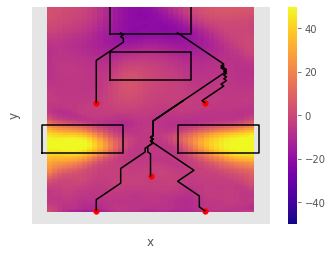

In [6]:
print(env.get_value(agent.Q_network))
env.visualize_analytic_comparison(agent.Q_network, True)
env.plot_trajectories(agent.Q_network, T=60, num_rnd_traj=5, states=env.visual_initial_states)

## Test --- Pendulum